# Configuration A - All tasks come from same dataset for training and validation set

In [4]:
!pip install medmnist
!pip install tensorboard
!pip install matplotlib

Looking in indexes: https://pypi.apple.com/simple, https://pypi.apple.com/simple

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.apple.com/simple, https://pypi.apple.com/simple

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.apple.com/simple, https://pypi.apple.com/simple

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F  # pylint: disable=unused-import
from torch.utils import tensorboard

from torch import autograd
torch.multiprocessing.set_sharing_strategy('file_system')
import os
import math

import medmnist
from medmnist import INFO, Evaluator

In [7]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
import sys
print("Python version:", sys.version)
platform = sys.platform

if platform == "linux":
    sys.stdout = open('/dev/stdout', 'w')
    import torch.multiprocessing
else:
    !pip install multiprocess
    import multiprocess

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
Python version: 3.9.13 (v3.9.13:6de2ca5339, May 17 2022, 11:37:23) 
[Clang 13.0.0 (clang-1300.0.29.30)]
Looking in indexes: https://pypi.apple.com/simple, https://pypi.apple.com/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Using cached https://pypi.apple.com/packages/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl (115 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


# We first work on a 2D dataset

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [12]:
data_flags = ['dermamnist']

# preprocessingt
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

download = True

for data_flag in data_flags:
    
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    classes = list(info['label'].values())
    
    DataClass = getattr(medmnist, info['python_class'])
    print(data_flag)
    print(task)
    
    train_dataset = DataClass(split='train', transform=data_transform, download=download)
    val_dataset = DataClass(split='val', transform=data_transform, download=False)
    test_dataset = DataClass(split='test', transform=data_transform, download=download)

    print(train_dataset)

dermamnist
multi-class
Using downloaded and verified file: /Users/angel/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/angel/.medmnist/dermamnist.npz
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /Users/angel/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a rati

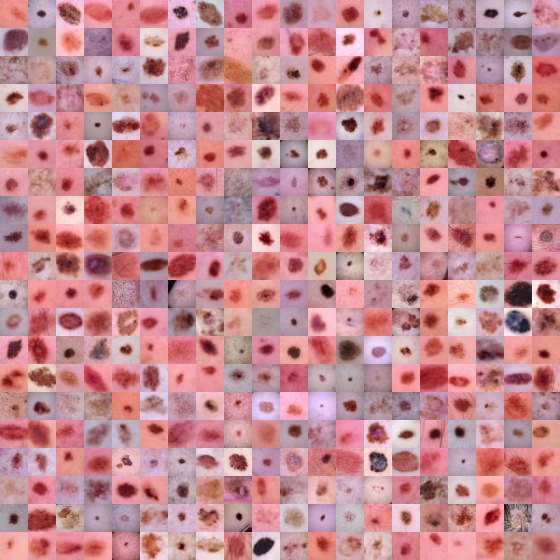

In [13]:
train_dataset.montage(length=20)

In [ ]:
from torch.utils.data import dataset, sampler, dataloader
from pathlib import Path

NUM_SAMPLES_PER_CLASS = 30

class MedMNISTDataset(dataset.Dataset):

    def __init__(self, medmnistdataset, split, num_way, num_support, num_query):
        super().__init__()

        info = INFO[medmnistdataset]
        task = info['task']
        n_channels = info['n_channels']
        n_classes = len(info['label'])
        DataClass = getattr(medmnist, info['python_class'])

        split_labels = None
        if (split == 'train'):
            split_labels = 'train_labels'
            dataset = DataClass(split='train', transform=data_transform, download=download)
        elif (split == 'val'):
            split_labels = 'val_labels'
            dataset = DataClass(split='val', transform=data_transform, download=download)
        elif (split == 'test'):
            split_labels = 'test_labels'
            dataset = DataClass(split='test', transform=data_transform, download=download)

        if platform == "linux":
            self.data = np.load(Path("/home/azureuser/.medmnist/" + medmnistdataset + ".npz"))
        else:
            self.data = np.load(Path("/Users/angel/.medmnist/" + medmnistdataset + ".npz"))
            
        all_labels = []
        for elem in self.data[split_labels]:
            all_labels.append(elem)

        num_classes = len(np.unique(all_labels))

        self.all_images = []
        for image,_ in dataset:
            self.all_images.append(image)
            
        self.images_indices = [None] * num_classes
        for i in range(num_classes):
            self.images_indices[i] = []
            
        for i, elem in enumerate(all_labels):
            if elem.item() >= num_classes: continue
            self.images_indices[elem.item()].append(i)
        
        # shuffle characters
        for i in range(num_classes):
            np.random.default_rng(0).shuffle(self.images_indices[i])

        # check problem arguments
        assert num_support + num_query <= NUM_SAMPLES_PER_CLASS
        self._num_support = num_support
        self._num_query = num_query
        self.split = split

    def __getitem__(self, class_idxs):
        """Constructs a task.

        Data for each class is sampled uniformly at random without replacement.

        Args:
            class_idxs (tuple[int]): class indices that comprise the task

        Returns:
            images_support (Tensor): task support images
                shape (num_way * num_support, channels, height, width)
            labels_support (Tensor): task support labels
                shape (num_way * num_support,)
            images_query (Tensor): task query images
                shape (num_way * num_query, channels, height, width)
            labels_query (Tensor): task query labels
                shape (num_way * num_query,)
        """
        images_support, images_query = [], []
        labels_support, labels_query = [], []

        for label in class_idxs:
            replace = False
            if self.split == 'val' or self.split == 'test':
                replace = True
            # get a class's examples and sample from them
            images_indices_label = np.random.default_rng().choice(
                self.images_indices[label],
                size=self._num_support + self._num_query,
                replace=replace
            )

            images = []
            for index in images_indices_label:
                images.append(self.all_images[index])
                
            # split sampled examples into support and query
            images_support.extend(images[:self._num_support])
            images_query.extend(images[self._num_support:])
            labels_support.extend([label] * self._num_support)
            labels_query.extend([label] * self._num_query)

        # aggregate into tensors
        images_support = torch.stack(images_support)  # shape (N*S, C, H, W)
        labels_support = torch.tensor(labels_support)  # shape (N*S)
        images_query = torch.stack(images_query)
        labels_query = torch.tensor(labels_query)

        return images_support, labels_support, images_query, labels_query


class MedMNISTSampler(sampler.Sampler):
    """Samples task specification keys for an MedMNISTDataset."""

    def __init__(self, split_idxs, num_way, num_tasks):
        """Inits OmniglotSampler.

        Args:
            split_idxs (range): indices that comprise the
                training/validation/test split
            num_way (int): number of classes per task
            num_tasks (int): number of tasks to sample
        """
        super().__init__(None)
        self._split_idxs = split_idxs
        self._num_way = num_way
        self._num_tasks = num_tasks

    def __iter__(self):
        return (
            np.random.default_rng().choice(
                self._split_idxs,
                size=self._num_way,
                replace=False
            ) for _ in range(self._num_tasks)
        )

    def __len__(self):
        return self._num_tasks


def identity(x):
    return x


def get_medmnist_dataloader(
        medmnistdataset,
        split,
        batch_size,
        num_way,
        num_support,
        num_query,
        num_tasks_per_epoch,
        num_workers=2,
):
    """Returns a dataloader.DataLoader for Omniglot.

    Args:
        split (str): one of 'train', 'val', 'test'
        batch_size (int): number of tasks per batch
        num_way (int): number of classes per task
        num_support (int): number of support examples per class
        num_query (int): number of query examples per class
        num_tasks_per_epoch (int): number of tasks before DataLoader is
            exhausted
    """
    split_idxs = range(num_way)

    return dataloader.DataLoader(
        dataset=MedMNISTDataset(medmnistdataset, split, num_way, num_support, num_query),
        batch_size=batch_size,
        sampler=MedMNISTSampler(split_idxs, num_way, num_tasks_per_epoch),
        num_workers=num_workers,
        multiprocessing_context="fork",
        collate_fn=identity,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )

In [ ]:
# # Test custom dataloader
# num_workers = 10
# if platform == "linux":
#     num_workers = 10

# dataloader_meta_train = get_medmnist_dataloader(
#         medmnistdataset='pathmnist',
#         split='train',
#         batch_size=8,
#         num_way=9,
#         num_support=1,
#         num_query=15,
#         num_tasks_per_epoch=240,
#         num_workers=num_workers,
#     )

# tasks = next(iter(dataloader_meta_train))
# for task in tasks:
#     images_support, labels_support, images_query, labels_query = task
#     print(images_support.shape)
#     print(labels_support.shape)
#     print(images_query.shape)
#     print(labels_query.shape)
#     break

# dataloader_meta_val = get_medmnist_dataloader(
#         medmnistdataset='bloodmnist',
#         split='val',
#         batch_size=8,
#         num_way=8,
#         num_support=1,
#         num_query=15,
#         num_tasks_per_epoch=240,
#         num_workers=num_workers,
#     )

# tasks = next(iter(dataloader_meta_val))
# for task in tasks:
#     images_support, labels_support, images_query, labels_query = task
#     print(images_support.shape)
#     print(labels_support.shape)
#     print(images_query.shape)
#     print(labels_query.shape)
#     break

# dataloader_meta_test = get_medmnist_dataloader(
#         medmnistdataset='dermamnist',
#         split='test',
#         batch_size=8,
#         num_way=7,
#         num_support=1,
#         num_query=15,
#         num_tasks_per_epoch=240,
#         num_workers=num_workers,
#     )

# tasks = next(iter(dataloader_meta_test))
# for task in tasks:
#     images_support, labels_support, images_query, labels_query = task
#     print(images_support.shape)
#     print(labels_support.shape)
#     print(images_query.shape)
#     print(labels_query.shape)
#     break

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
confusion_matrix_data = np.zeros([7,7], int)
all_labels = []
all_preds = []

def score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """

    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]
    predictions = torch.argmax(logits, dim=-1)
    y = predictions == labels

    for i, l in enumerate(labels):
        all_labels.append(l.item())
        all_preds.append(predictions[i].item())
        confusion_matrix_data[l.item(), predictions[i].item()] += 1 

    for i in range(n_classes):
        label = labels[i]
        class_correct[label] += y[i].item()
        class_total[label] += 1
        if class_total[i] == 0: continue
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
        
    y = y.type(torch.float)

    return torch.mean(y).item()

In [ ]:
NUM_INPUT_CHANNELS = 3
NUM_HIDDEN_CHANNELS = 32
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 8
SUMMARY_INTERVAL = 10
SAVE_INTERVAL = 100
LOG_INTERVAL = 10
VAL_INTERVAL = LOG_INTERVAL * 5
NUM_TEST_TASKS = 100

class MAML:
    """Trains and assesses a MAML."""

    def __init__(
            self,
            num_outputs,
            num_inner_steps,
            inner_lr,
            learn_inner_lrs,
            outer_lr,
            log_dir,
            device
    ):
        """Inits MAML.

        The network consists of four convolutional blocks followed by a linear
        head layer. Each convolutional block comprises a convolution layer, a
        batch normalization layer, and ReLU activation.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.

        Args:
            num_outputs (int): dimensionality of output, i.e. number of classes
                in a task
            num_inner_steps (int): number of inner-loop optimization steps
            inner_lr (float): learning rate for inner-loop optimization
                If learn_inner_lrs=True, inner_lr serves as the initialization
                of the learning rates.
            learn_inner_lrs (bool): whether to learn the above
            outer_lr (float): learning rate for outer-loop optimization
            log_dir (str): path to logging directory
            device (str): device to be used
        """
        meta_parameters = {}

        self.device = device

        # construct feature extractor
        in_channels = NUM_INPUT_CHANNELS
        for i in range(NUM_CONV_LAYERS):
            meta_parameters[f'conv{i}'] = nn.init.xavier_uniform_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    in_channels,
                    KERNEL_SIZE,
                    KERNEL_SIZE,
                    requires_grad=True,
                    device=self.device
                )
            )
            meta_parameters[f'b{i}'] = nn.init.zeros_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    requires_grad=True,
                    device=self.device
                )
            )
            in_channels = NUM_HIDDEN_CHANNELS

        # construct linear head layer
        meta_parameters[f'w{NUM_CONV_LAYERS}'] = nn.init.xavier_uniform_(
            torch.empty(
                num_outputs,
                NUM_HIDDEN_CHANNELS,
                requires_grad=True,
                device=self.device
            )
        )
        meta_parameters[f'b{NUM_CONV_LAYERS}'] = nn.init.zeros_(
            torch.empty(
                num_outputs,
                requires_grad=True,
                device=self.device
            )
        )

        self._meta_parameters = meta_parameters
        self._num_inner_steps = num_inner_steps
        self._inner_lrs = {
            k: torch.tensor(inner_lr, requires_grad=learn_inner_lrs)
            for k in self._meta_parameters.keys()
        }
        self._outer_lr = outer_lr

        self._optimizer = torch.optim.Adam(
            list(self._meta_parameters.values()) +
            list(self._inner_lrs.values()),
            lr=self._outer_lr
        )
        self._log_dir = log_dir
        os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _forward(self, images, parameters):
        """Computes predicted classification logits.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)
            parameters (dict[str, Tensor]): parameters to use for
                the computation

        Returns:
            a Tensor consisting of a batch of logits
                shape (num_images, classes)
        """
        x = images
        for i in range(NUM_CONV_LAYERS):
            x = F.conv2d(
                input=x,
                weight=parameters[f'conv{i}'],
                bias=parameters[f'b{i}'],
                stride=1,
                padding='same'
            )
            x = F.batch_norm(x, None, None, training=True)
            x = F.leaky_relu(x)
        x = torch.mean(x, dim=[2, 3])
        return F.linear(
            input=x,
            weight=parameters[f'w{NUM_CONV_LAYERS}'],
            bias=parameters[f'b{NUM_CONV_LAYERS}']
        )

    def _inner_loop(self, images, labels, train):
        """Computes the adapted network parameters via the MAML inner loop.

        Args:
            images (Tensor): task support set inputs
                shape (num_images, channels, height, width)
            labels (Tensor): task support set outputs
                shape (num_images,)
            train (bool): whether we are training or evaluating

        Returns:
            parameters (dict[str, Tensor]): adapted network parameters
            accuracies (list[float]): support set accuracy over the course of
                the inner loop, length num_inner_steps + 1
            gradients(list[float]): gradients computed from auto.grad, just needed
                for autograders, no need to use this value in your code and feel to replace
                with underscore       
        """
        accuracies = []
        parameters = {
            k: torch.clone(v)
            for k, v in self._meta_parameters.items()
        }
        gradients = None
        ### START CODE HERE ###
        # TODO: finish implementing this method.
        # This method computes the inner loop (adaptation) procedure
        # over the course of _num_inner_steps steps for one
        # task. It also scores the model along the way.
        # Make sure to populate accuracies and update parameters.
        # Use F.cross_entropy to compute classification losses.
        # Use util.score to compute accuracies.
        for _ in range(self._num_inner_steps):
            support_features = self._forward(images, parameters=parameters)
            loss = F.cross_entropy(support_features, labels.squeeze())

            if train:
                gradients = autograd.grad(loss, parameters.values(), create_graph=True)
            else:
                gradients = autograd.grad(loss, parameters.values(), create_graph=False)

            layers = list(parameters.keys())
            for i in range(len(layers)): parameters[layers[i]] = parameters[layers[i]] - self._inner_lrs[layers[i]] * gradients[i]
            accuracies.append(score(support_features, labels.squeeze()))

        # Batch accuracy
        batch_features = self._forward(images, parameters)
        accuracies.append(score(batch_features, labels.squeeze()))

        ### END CODE HERE ###
        return parameters, accuracies, gradients

    def _outer_step(self, task_batch, train):
        """Computes the MAML loss and metrics on a batch of tasks.

        Args:
            task_batch (tuple): batch of tasks from an Omniglot DataLoader
            train (bool): whether we are training or evaluating

        Returns:
            outer_loss (Tensor): mean MAML loss over the batch, scalar
            accuracies_support (ndarray): support set accuracy over the
                course of the inner loop, averaged over the task batch
                shape (num_inner_steps + 1,)
            accuracy_query (float): query set accuracy of the adapted
                parameters, averaged over the task batch
        """
        outer_loss_batch = []
        accuracies_support_batch = []
        accuracy_query_batch = []
        for i, task in enumerate(task_batch):
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(self.device)
            labels_support = labels_support.to(self.device)
            images_query = images_query.to(self.device)
            labels_query = labels_query.to(self.device)

            parameters, support_accuraccies, _ = self._inner_loop(images_support, labels_support, train)

            query_features = self._forward(images_query, parameters)
            loss = F.cross_entropy(query_features, labels_query.squeeze())
            outer_loss_batch.append(loss)

            accuracies_support_batch.append(support_accuraccies)
            query_accuracies = score(query_features, labels_query.squeeze())
            accuracy_query_batch.append(query_accuracies)
            ### END CODE HERE ###
        outer_loss = torch.mean(torch.stack(outer_loss_batch))
        accuracies_support = np.mean(
            accuracies_support_batch,
            axis=0
        )
        accuracy_query = np.mean(accuracy_query_batch)
        return outer_loss, accuracies_support, accuracy_query

    def train(self, dataloader_meta_train, dataloader_meta_val, writer):
        """Train the MAML.

        Consumes dataloader_meta_train to optimize MAML meta-parameters
        while periodically validating on dataloader_meta_val, logging metrics, and
        saving checkpoints.

        Args:
            dataloader_meta_train (DataLoader): loader for train tasks
            dataloader_meta_val (DataLoader): loader for validation tasks
            writer (SummaryWriter): TensorBoard logger
        """
        print(f'Starting training at iteration {self._start_train_step}.')
        for i_step, task_batch in enumerate(
                dataloader_meta_train,
                start=self._start_train_step
        ):
            self._optimizer.zero_grad()
            outer_loss, accuracies_support, accuracy_query = (                self._outer_step(task_batch, train=True)
            )
            outer_loss.backward()
            self._optimizer.step()

            if i_step % LOG_INTERVAL == 0:
                print(
                    f'Iteration {i_step}: '
                    f'loss: {outer_loss.item():.3f}, '
                    f'pre-adaptation support accuracy: '
                    f'{accuracies_support[0]:.3f}, '
                    f'post-adaptation support accuracy: '
                    f'{accuracies_support[-1]:.3f}, '
                    f'post-adaptation query accuracy: '
                    f'{accuracy_query:.3f}'
                )
                writer.add_scalar('loss/train', outer_loss.item(), i_step)
                writer.add_scalar(
                    'train_accuracy/pre_adapt_support',
                    accuracies_support[0],
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/post_adapt_support',
                    accuracies_support[-1],
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/post_adapt_query',
                    accuracy_query,
                    i_step
                )

            if i_step % VAL_INTERVAL == 0:
                losses = []
                accuracies_pre_adapt_support = []
                accuracies_post_adapt_support = []
                accuracies_post_adapt_query = []
                for val_task_batch in dataloader_meta_val:
                    outer_loss, accuracies_support, accuracy_query = (
                        self._outer_step(val_task_batch, train=False)
                    )
                    if (math.isnan(outer_loss.item())): break
                    losses.append(outer_loss.item())
                    accuracies_pre_adapt_support.append(accuracies_support[0])
                    accuracies_post_adapt_support.append(accuracies_support[-1])
                    accuracies_post_adapt_query.append(accuracy_query)
                loss = np.mean(losses)
                accuracy_pre_adapt_support = np.mean(
                    accuracies_pre_adapt_support
                )
                accuracy_post_adapt_support = np.mean(
                    accuracies_post_adapt_support
                )
                accuracy_post_adapt_query = np.mean(
                    accuracies_post_adapt_query
                )
                print(
                    f'Validation: '
                    f'loss: {loss:.3f}, '
                    f'pre-adaptation support accuracy: '
                    f'{accuracy_pre_adapt_support:.3f}, '
                    f'post-adaptation support accuracy: '
                    f'{accuracy_post_adapt_support:.3f}, '
                    f'post-adaptation query accuracy: '
                    f'{accuracy_post_adapt_query:.3f}'
                )
                writer.add_scalar('loss/val', loss, i_step)
                writer.add_scalar(
                    'val_accuracy/pre_adapt_support',
                    accuracy_pre_adapt_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/post_adapt_support',
                    accuracy_post_adapt_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/post_adapt_query',
                    accuracy_post_adapt_query,
                    i_step
                )

            if i_step % SAVE_INTERVAL == 0:
                self._save(i_step)

    def test(self, dataloader_test):
        """Evaluate the MAML on test tasks.

        Args:
            dataloader_test (DataLoader): loader for test tasks
        """
        accuracies = []
        for task_batch in dataloader_test:
            _, _, accuracy_query = self._outer_step(task_batch, train=False)
            if (math.isnan(accuracy_query.item())): break
            accuracies.append(accuracy_query)
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        mean_95_confidence_interval = 1.96 * std / np.sqrt(NUM_TEST_TASKS)
        print(
            f'Accuracy over {NUM_TEST_TASKS} test tasks: '
            f'mean {mean:.3f}, '
            f'95% confidence interval {mean_95_confidence_interval:.3f}'
        )

    def load(self, checkpoint_step):
        """Loads a checkpoint.

        Args:
            checkpoint_step (int): iteration of checkpoint to load

        Raises:
            ValueError: if checkpoint for checkpoint_step is not found
        """
        target_path = (
            f'{os.path.join(self._log_dir, "state")}'
            f'{checkpoint_step}.pt'
        )
        if os.path.isfile(target_path):
            state = torch.load(target_path)
            self._meta_parameters = state['meta_parameters']
            self._inner_lrs = state['inner_lrs']
            self._optimizer.load_state_dict(state['optimizer_state_dict'])
            self._start_train_step = checkpoint_step + 1
            print(f'Loaded checkpoint iteration {checkpoint_step}.')
        else:
            raise ValueError(
                f'No checkpoint for iteration {checkpoint_step} found.'
            )

    def _save(self, checkpoint_step):
        """Saves parameters and optimizer state_dict as a checkpoint.

        Args:
            checkpoint_step (int): iteration to label checkpoint with
        """
        optimizer_state_dict = self._optimizer.state_dict()
        torch.save(
            dict(meta_parameters=self._meta_parameters,
                 inner_lrs=self._inner_lrs,
                 optimizer_state_dict=optimizer_state_dict),
            f'{os.path.join(self._log_dir, "state")}{checkpoint_step}.pt'
        )
        print('Saved checkpoint.')

In [ ]:
DEVICE = "cpu"
# DEVICE = "mps"
if platform == "linux":
    DEVICE = "cuda"

log_dir = None
writer = None

log_dir = f'./logs/maml/'  # pylint: disable=line-too-long
writer = tensorboard.SummaryWriter(log_dir=log_dir)

In [ ]:
num_way = 7
num_inner_steps = 1
inner_lr = 15.0
learn_inner_lrs = True
learning_rate = 0.01
num_workers = 10

maml = MAML(
    num_way,
    num_inner_steps,
    inner_lr,
    learn_inner_lrs,
    learning_rate,
    log_dir,
    DEVICE
)

batch_size = 8
num_way = 7
num_support = 5
num_query = 15
num_training_tasks = 8000

dataloader_meta_train = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='train',
        batch_size=batch_size,
        num_way=num_way,
        num_support=num_support,
        num_query=num_query,
        num_tasks_per_epoch=num_training_tasks,
        num_workers=num_workers,
    )

dataloader_meta_val = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='val',
        batch_size=batch_size, #2
        num_way=num_way,
        num_support=num_support,
        num_query=num_query, 
        num_tasks_per_epoch=num_training_tasks, # 2
        num_workers=num_workers,
    )

maml.train(
    dataloader_meta_train,
    dataloader_meta_val,
    writer
)

# maml.load(checkpoint_step = 900)

dataloader_meta_test = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='test',
        batch_size=1,
        num_way=num_way,
        num_support=num_support,
        num_query=num_query,
        num_tasks_per_epoch=NUM_TEST_TASKS,
        num_workers=num_workers,
    )

maml.test(dataloader_meta_test)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=8) 

labels = list(range(n_classes))
for i, r in enumerate(confusion_matrix_data):
    print(str(classes[i]) + "acc" + str(r[i]/np.sum(r)*100))

fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.matshow(confusion_matrix_data, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(n_classes), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(n_classes), labels)
plt.savefig('figure.png')

In [ ]:
NUM_INPUT_CHANNELS = 3
NUM_HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 4
SUMMARY_INTERVAL = 10
SAVE_INTERVAL = 100
PRINT_INTERVAL = 10
VAL_INTERVAL = PRINT_INTERVAL * 5
NUM_TEST_TASKS = 100

class ProtoNetNetwork(nn.Module):
    """Container for ProtoNet weights and image-to-latent computation."""

    def __init__(self, device):
        """Inits ProtoNetNetwork.

        The network consists of four convolutional blocks, each comprising a
        convolution layer, a batch normalization layer, ReLU activation, and 2x2
        max pooling for downsampling. There is an additional flattening
        operation at the end.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.

        Args:
            device (str): device to be used
        """
        super().__init__()
        layers = []
        in_channels = NUM_INPUT_CHANNELS
        for _ in range(NUM_CONV_LAYERS):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    NUM_HIDDEN_CHANNELS,
                    (KERNEL_SIZE, KERNEL_SIZE),
                    padding='same'
                )
            )
            layers.append(nn.BatchNorm2d(NUM_HIDDEN_CHANNELS))
            layers.append(nn.LeakyReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = NUM_HIDDEN_CHANNELS
        layers.append(nn.Flatten())
        self._layers = nn.Sequential(*layers)
        self.to(device)

    def forward(self, images):
        """Computes the latent representation of a batch of images.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)

        Returns:
            a Tensor containing a batch of latent representations
                shape (num_images, latents)
        """
        return self._layers(images)


class ProtoNet:
    """Trains and assesses a prototypical network."""

    def __init__(self, learning_rate, log_dir, device, compile=False, backend=None, learner=None, val_interval=None, save_interval=None, bio=False):
        """Inits ProtoNet.

        Args:
            learning_rate (float): learning rate for the Adam optimizer
            log_dir (str): path to logging directory
            device (str): device to be used
        """
        self.device = device
        if learner is None:
            self._network = ProtoNetNetwork(device)
        else: 
            self._network = learner.to(device)

        self.val_interval = VAL_INTERVAL if val_interval is None else val_interval
        self.save_interval = SAVE_INTERVAL if save_interval is None else save_interval
        self.bio = bio

        if(compile == True):
            try:
                self._network = torch.compile(self._network, backend=backend)
                print(f"ProtoNetNetwork model compiled")
            except Exception as err:
                print(f"Model compile not supported: {err}")

        self._optimizer = torch.optim.Adam(
            self._network.parameters(),
            lr=learning_rate
        )
        self._log_dir = log_dir
        os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _step(self, task_batch):
        """Computes ProtoNet mean loss (and accuracy) on a batch of tasks.

        Args:
            task_batch (tuple[Tensor, Tensor, Tensor, Tensor]):
                batch of tasks from an Omniglot DataLoader

        Returns:
            a Tensor containing mean ProtoNet loss over the batch
                shape ()
            mean support set accuracy over the batch as a float
            mean query set accuracy over the batch as a float
        """
        loss_batch = []
        accuracy_support_batch = []
        accuracy_query_batch = []
        for i, task in enumerate(task_batch):
            # print(i)
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(self.device)
            labels_support = labels_support.to(self.device)
            images_query = images_query.to(self.device)
            labels_query = labels_query.to(self.device)

            ### START CODE HERE ###
            # TODO: finish implementing this method.
            # For a given task, compute the prototypes and the protonet loss.
            # Use F.cross_entropy to compute classification losses.
            # Use util.score to compute accuracies.
            # Make sure to populate loss_batch, accuracy_support_batch, and
            # accuracy_query_batch.
            loss_batch, accuracy_support_batch, accuracy_query_batch
            # compute prototypes without tracking gradients
                # Generate support features
            support_features = self._network.forward(images_support)
            # Calculate prototypes from features
            prototypes = []
            n  = torch.unique(labels_support).shape[-1]
            for i in range(n):
                indices = (labels_support == i).nonzero()
                class_features = support_features[indices]
                with torch.no_grad():
                    prototypes.append(torch.mean(class_features, dim=0))
                # Calculate features for support
            prototypes = torch.cat(prototypes)
            support_features = torch.stack([support_features] * prototypes.size(0), dim=1)
            supp_diffs = torch.sub(support_features, prototypes)
            supp_sq_norms = torch.linalg.norm(supp_diffs,ord=2,dim=2).square()
            accuracy_support_batch.append(score(-supp_sq_norms, labels_support))

            # Generate query features
            query_features = self._network.forward(images_query)
            query_features_batch = torch.stack([query_features] * prototypes.size(0), dim=1)
            query_diffs = torch.sub(query_features_batch, prototypes)
            query_sq_norms = torch.linalg.norm(query_diffs,ord=2,dim=2).square()
            accuracy_query_batch.append(score(-query_sq_norms, labels_query))
            # Compute loss
            loss_batch.append(F.cross_entropy(-query_sq_norms, labels_query))
            ### END CODE HERE ###

            # ********************************************************
            # ******************* YOUR CODE HERE *********************
            # ********************************************************
        return (
            torch.mean(torch.stack(loss_batch)),
            np.mean(accuracy_support_batch),
            np.mean(accuracy_query_batch)
        )

    def train(self, dataloader_meta_train, dataloader_meta_val, writer):
        """Train the ProtoNet.

        Consumes dataloader_meta_train to optimize weights of ProtoNetNetwork
        while periodically validating on dataloader_meta_val, logging metrics, and
        saving checkpoints.

        Args:
            dataloader_meta_train (DataLoader): loader for train tasks
            dataloader_meta_val (DataLoader): loader for validation tasks
            writer (SummaryWriter): TensorBoard logger
        """
        print(f'Starting training at iteration {self._start_train_step}.')
        MAX_TRAIN = len(dataloader_meta_train)
        # exit()
        for i_step, task_batch in enumerate(
                dataloader_meta_train,
                start=self._start_train_step
        ):
            if i_step > MAX_TRAIN:
                break
            self._optimizer.zero_grad()
            loss, accuracy_support, accuracy_query = self._step(task_batch)
            loss.backward()
            self._optimizer.step()

            if i_step % PRINT_INTERVAL == 0:
                print(
                    f'Iteration {i_step}: '
                    f'loss: {loss.item():.3f}, '
                    f'support accuracy: {accuracy_support.item():.3f}, '
                    f'query accuracy: {accuracy_query.item():.3f}'
                )
                writer.add_scalar('loss/train', loss.item(), i_step)
                writer.add_scalar(
                    'train_accuracy/support',
                    accuracy_support.item(),
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/query',
                    accuracy_query.item(),
                    i_step
                )

            if i_step % self.val_interval == 0:
                print("Start Validation...")
                with torch.no_grad():
                    losses, accuracies_support, accuracies_query = [], [], []
                    for i, val_task_batch in enumerate(dataloader_meta_val):
                        if self.bio and i > 600:
                            break
                        loss, accuracy_support, accuracy_query = (
                            self._step(val_task_batch)
                        )
                        losses.append(loss.item())
                        accuracies_support.append(accuracy_support)
                        accuracies_query.append(accuracy_query)
                    loss = np.mean(losses)
                    accuracy_support = np.mean(accuracies_support)
                    accuracy_query = np.mean(accuracies_query)
                    ci95 = 1.96 * np.std(accuracies_query) / np.sqrt(600 * 4)
                if self.bio:
                    print(
                        f'Validation: '
                        f'loss: {loss:.3f}, '
                        f'support accuracy: {accuracy_support:.3f}, '
                        f'query accuracy: {accuracy_query:.3f}',
                        f'Ci95: {ci95:.3f}'
                    )
                else: 
                    print(
                        f'Validation: '
                        f'loss: {loss:.3f}, '
                        f'support accuracy: {accuracy_support:.3f}, '
                        f'query accuracy: {accuracy_query:.3f}'
                    )
                writer.add_scalar('loss/val', loss, i_step)
                writer.add_scalar(
                    'val_accuracy/support',
                    accuracy_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/query',
                    accuracy_query,
                    i_step
                )
                if self.bio:
                    writer.add_scalar(
                        'val_accuracy/ci95',
                        ci95,
                        i_step
                    )
            if i_step % self.save_interval == 0:
                self._save(i_step)

    def test(self, dataloader_test):
        """Evaluate the ProtoNet on test tasks.

        Args:
            dataloader_test (DataLoader): loader for test tasks
        """
        accuracies = []
        for i, task_batch in enumerate(dataloader_test):
            accuracies.append(self._step(task_batch)[2])
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        mean_95_confidence_interval = 1.96 * std / np.sqrt(NUM_TEST_TASKS)
        print(
            f'Accuracy over {NUM_TEST_TASKS} test tasks: '
            f'mean {mean:.3f}, '
            f'95% confidence interval {mean_95_confidence_interval:.3f}'
        )

    def load(self, checkpoint_step, filename=""):
        """Loads a checkpoint.

        Args:
            checkpoint_step (int): iteration of checkpoint to load
            filename (str): directly setting name of checkpoint file, default ="", when argument is passed, then checkpoint will be ignored

        Raises:
            ValueError: if checkpoint for checkpoint_step is not found
        """
        target_path = (
            f'{os.path.join(self._log_dir, "state")}'
            f'{checkpoint_step}.pt'
        ) if filename == "" else filename
        if os.path.isfile(target_path):
            state = torch.load(target_path)
            self._network.load_state_dict(state['network_state_dict'])
            self._optimizer.load_state_dict(state['optimizer_state_dict'])
            self._start_train_step = checkpoint_step + 1
            print(f'Loaded checkpoint iteration {checkpoint_step}.')
        else:
            raise ValueError(
                f'No checkpoint for iteration {checkpoint_step} found.'
            )

    def _save(self, checkpoint_step):
        """Saves network and optimizer state_dicts as a checkpoint.

        Args:
            checkpoint_step (int): iteration to label checkpoint with
        """
        torch.save(
            dict(network_state_dict=self._network.state_dict(),
                 optimizer_state_dict=self._optimizer.state_dict()),
            f'{os.path.join(self._log_dir, "state")}{checkpoint_step}.pt'
        )
        print('Saved checkpoint.')

In [ ]:
learning_rate = 0.001
backend = 'inductor'

batch_size = 16
num_way = 7
num_support = 10
num_query = 15
num_training_tasks = 8000

log_dir = f'./logs/protonet/'  # pylint: disable=line-too-long
writer = tensorboard.SummaryWriter(log_dir=log_dir)

dataloader_meta_train = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='train',
        batch_size=batch_size,
        num_way=num_way,
        num_support=num_support,
        num_query=num_query,
        num_tasks_per_epoch=num_training_tasks,
        num_workers=num_workers,
    )

dataloader_meta_val = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='val',
        batch_size=batch_size, #2
        num_way=num_way,
        num_support=num_support,
        num_query=num_query, 
        num_tasks_per_epoch=num_training_tasks, # 2
        num_workers=num_workers,
    )

protonet = ProtoNet(learning_rate, log_dir, DEVICE, backend)

protonet.train(
        dataloader_meta_train,
        dataloader_meta_val,
        writer
    )

dataloader_meta_test = get_medmnist_dataloader(
        medmnistdataset='dermamnist',
        split='test',
        batch_size=1,
        num_way=num_way,
        num_support=num_support,
        num_query=num_query,
        num_tasks_per_epoch=NUM_TEST_TASKS,
        num_workers=num_workers,
    )

protonet.test(dataloader_meta_test)